# Interactive Demo for Fors2 with Photometry only
This is a deconstructed version of the demo that is intended to show a bit more detail about the operation of *prospector*.


- author (adaptation) : Sylvie Dagoret-Campagne
- creation date : 2023-06-14
- last update : 2023-06-14


First let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
from matplotlib.pyplot import *
import re
import h5py
import pandas as pd
%matplotlib inline
from collections import OrderedDict

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

**Prospector** utilizes three main packages:
- **fsps**, which governs the fundamental stellar population synthesis models (via the **python-fsps** package),
- **sedpy**, which contains some routines for computing projecting spectra onto filter bandpasses, and
- **prospect**, which is where the likelihood evaluations, parameter priors, and posterior sampling takes place.

Let's import those now.

In [3]:
import fsps
import sedpy
import prospect

And now, let's just look at the versions so you know what's working for me

In [4]:
vers = (np.__version__, scipy.__version__, h5py.__version__, fsps.__version__, prospect.__version__)
print("numpy: {}\nscipy: {}\nh5py: {}\nfsps: {}\nprospect: {}".format(*vers))

numpy: 1.23.5
scipy: 1.10.1
h5py: 3.7.0
fsps: 0.4.3
prospect: 1.2.1.dev23+g09a83f2


We'll also use external packages for sampling the posterior.  Let's make sure we have those now.

In [5]:
import emcee
import dynesty

In [6]:
ordered_keys = ['name','num','ra','dec', 'redshift','Rmag','RT', 'RV','eRV','Nsp','lines',
                'ra_galex','dec_galex','fuv_mag', 'fuv_magerr','nuv_mag', 'nuv_magerr', 
                'fuv_flux', 'fuv_fluxerr','nuv_flux', 'nuv_fluxerr','asep_galex',
                'ID', 'KIDS_TILE','RAJ2000','DECJ2000','Z_ML', 'Z_B','asep_kids','CLASS_STAR',
                'MAG_GAAP_u','MAG_GAAP_g','MAG_GAAP_r','MAG_GAAP_i','MAG_GAAP_Z','MAG_GAAP_Y','MAG_GAAP_J', 'MAG_GAAP_H','MAG_GAAP_Ks',
                'MAGERR_GAAP_u','MAGERR_GAAP_g','MAGERR_GAAP_r','MAGERR_GAAP_i','MAGERR_GAAP_Z','MAGERR_GAAP_Y','MAGERR_GAAP_J','MAGERR_GAAP_H','MAGERR_GAAP_Ks',
                'FLUX_GAAP_u','FLUX_GAAP_g','FLUX_GAAP_r','FLUX_GAAP_i','FLUX_GAAP_Z','FLUX_GAAP_Y','FLUX_GAAP_J', 'FLUX_GAAP_H','FLUX_GAAP_Ks',
                'FLUXERR_GAAP_u','FLUXERR_GAAP_g','FLUXERR_GAAP_r','FLUXERR_GAAP_i','FLUXERR_GAAP_Z','FLUXERR_GAAP_Y','FLUXERR_GAAP_J','FLUXERR_GAAP_H','FLUXERR_GAAP_Ks',
                'FLUX_RADIUS', 'EXTINCTION_u','EXTINCTION_g','EXTINCTION_r', 'EXTINCTION_i',]

In [7]:
class Fors2DataAcess(object):
    def __init__(self,filename):
        if os.path.isfile(filename):
            self.hf = h5py.File(filename, 'r')
            self.list_of_groupkeys = list(self.hf.keys())      
             # pick one key    
            key_sel =  self.list_of_groupkeys[0]
            # pick one group
            group = self.hf.get(key_sel)  
            #pickup all attribute names
            self.list_of_subgroup_keys = []
            for k in group.attrs.keys():
                self.list_of_subgroup_keys.append(k)
        else:
            self.hf = None
            self.list_of_groupkeys = []
            self.list_of_subgroup_keys = []
    def close_file(self):
        self.hf.close() 
        
    def get_list_of_groupkeys(self):
        return self.list_of_groupkeys 
    def get_list_subgroup_keys(self):
        return self.list_of_subgroup_keys
    def getattribdata_fromgroup(self,groupname):
        attr_dict = OrderedDict()
        if groupname in self.list_of_groupkeys:       
            group = self.hf.get(groupname)  
            for  nameval in self.list_of_subgroup_keys:
                attr_dict[nameval] = group.attrs[nameval]
        else:
            print(f'getattribdata_fromgroup : No group {groupname}')
        return attr_dict
    def getspectrum_fromgroup(self,groupname):
        spec_dict = {}
        if groupname in self.list_of_groupkeys:       
            group = self.hf.get(groupname)  
            wl = np.array(group.get("wl"))
            fl = np.array(group.get("fl")) 
            spec_dict["wl"] = wl
            spec_dict["fl"] = fl
        else:
            print(f'getspectrum_fromgroup : No group {groupname}')
        return spec_dict
    
    #kernel = kernels.RBF(0.5, (8000, 10000.0))
    #gp = GaussianProcessRegressor(kernel=kernel ,random_state=0)

    def getspectrumcleanedemissionlines_fromgroup(self,groupname,gp,nsigs=8):
        spec_dict = {}
        if groupname in self.list_of_groupkeys:       
            group = self.hf.get(groupname)  
            wl = np.array(group.get("wl"))
            fl = np.array(group.get("fl")) 
            # fit gaussian pricess 
            X = wl
            Y = fl
            
            DeltaY = Y - gp.predict(X[:, None], return_std=False)
            background = np.sqrt(np.median(DeltaY**2))
            indexes_toremove = np.where(np.abs(DeltaY)> nsigs * background)[0]
            
            Xclean = np.delete(X,indexes_toremove)
            Yclean  = np.delete(Y,indexes_toremove)
            
            spec_dict["wl"] = Xclean
            spec_dict["fl"] = Yclean
    
            
        else:
            print(f'getspectrum_fromgroup : No group {groupname}')
        return spec_dict
        
        
           
         

# Setup

*Prospector* requires several ingredients to conduct a fit.  These are:
  1. An `obs` dictionary (with the data we intend to fit)
  2. A stellar population synthesis object (a *source*) to predict spectra from parameters
  3. A `model` object (to describe, store, and translate parameters and priors)
  4. A likelihood or posterior probability function
  
It can also useful to collect the meta-parameters controlling how these ingredients are created and how the fit is conducted in a ``run_params`` dictionary. We will do that as we go along.  We will also encapsulate each step of the setup in a series of `build_x()` functions.

## The data to be fit: `build_obs()`

The data to be fit is stored in a dictionary that we will call `obs`.
The `obs` dictionary stores the observed fluxes, uncertainties, and information about how those fluxes were measured.
For spectra this means the wavelengths at which the fluxes were measured, while for photometry we must know the filters through which the fluxes were measured.
This information is passed (via the `obs` dictionary) to the model object to specify which data to predict.  It is also passed to the likelihood functions for calculating the likelihood of the data for a given model.

**Units:** The units of the fluxes and uncertainties are assumed to be maggies (i.e Jy/3631).
The wavelength units are assumed to be observed frame vacuum angstroms.  Also note that mask values should be `True` for data that you want to fit, and `False` for data that is to be ignored in the likelihood calculation.

We will create an `obs` dictionary below, with all of the required keys, starting with photometry.
We will do this through a `build_obs` method, that takes some meta-parameters.
In this example we use photometry from a row in Table 2 of Johnson et al. 2013

In [8]:
input_file_h5  = '../../../../QueryCatalogs/data/FORS2spectraGalexKidsPhotom.hdf5'

In [9]:
fors2 = Fors2DataAcess(input_file_h5)

In [10]:
list_of_keys = fors2.get_list_of_groupkeys()
list_of_attributes = fors2.get_list_subgroup_keys()
list_of_keys = np.array(list_of_keys)
list_of_keysnum = [ int(re.findall("SPEC(.*)",specname)[0]) for specname in  list_of_keys ]
sorted_indexes = np.argsort(list_of_keysnum)
list_of_keys = list_of_keys[sorted_indexes]

In [11]:
df_info = pd.DataFrame(columns=list_of_attributes)

In [12]:
kernel = kernels.RBF(0.5, (8000, 10000.0))
gp = GaussianProcessRegressor(kernel=kernel ,random_state=0)

In [13]:
selected_key = 'SPEC214'
output_tag = selected_key + '_photomonly'

In [14]:
attrs = fors2.getattribdata_fromgroup(selected_key)
spectr = fors2.getspectrumcleanedemissionlines_fromgroup(selected_key,gp)
df_info.loc[0] = [*attrs.values()] # hope the order of attributes is kept

In [15]:
attrs

OrderedDict([('CLASS_STAR', 0.0285597592592239),
             ('DECJ2000', -28.423075),
             ('EXTINCTION_g', 0.0597145706415176),
             ('EXTINCTION_i', 0.0306979492306709),
             ('EXTINCTION_r', 0.0413102693855762),
             ('EXTINCTION_u', 0.0766364112496376),
             ('FLUXERR_GAAP_H', 584.3170166015625),
             ('FLUXERR_GAAP_J', 284.14215087890625),
             ('FLUXERR_GAAP_Ks', 679.517578125),
             ('FLUXERR_GAAP_Y', 348.23663330078125),
             ('FLUXERR_GAAP_Z', 178.92771911621094),
             ('FLUXERR_GAAP_g', 3.3600001253519807e-11),
             ('FLUXERR_GAAP_i', 1.7600000623563259e-10),
             ('FLUXERR_GAAP_r', 3.519999916545835e-11),
             ('FLUXERR_GAAP_u', 1.2499999646475854e-10),
             ('FLUX_GAAP_H', 17384.017578125),
             ('FLUX_GAAP_J', 14311.908203125),
             ('FLUX_GAAP_Ks', 21491.59765625),
             ('FLUX_GAAP_Y', 12392.03515625),
             ('FLUX_GAAP_Z', 12035

In [16]:
df_info = df_info[ordered_keys]
df_info

,name,num,ra,dec,redshift,Rmag,RT,RV,eRV,Nsp,...,FLUXERR_GAAP_Z,FLUXERR_GAAP_Y,FLUXERR_GAAP_J,FLUXERR_GAAP_H,FLUXERR_GAAP_Ks,FLUX_RADIUS,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i
0,SPEC214,214,13.5485,-28.42296,0.29266,19.8,16.1,87798,23,1,...,178.927719,348.236633,284.142151,584.317017,679.517578,4.76632,0.076636,0.059715,0.04131,0.030698


In [17]:
object_redshift = df_info["redshift"]

In [18]:
def build_obs(attrs, spectr, **extras):
    """Build a dictionary of observational data.  
        into apparent magnitudes.
        
    :returns obs:
        A dictionary of observational data to use in the fit.
    """
    from prospect.utils.obsutils import fix_obs
    import sedpy

    # The obs dictionary, empty for now
    obs = {}

    # These are the names of the relevant filters, 
    # in the same order as the photometric data (see below)
    galex = ['galex_FUV', 'galex_NUV']
    vista = ['vista_vircam_'+n for n in ['Z','J','H','Ks']]
    sdss = ['sdss_{0}0'.format(b) for b in ['u','g','r','i']]
    filternames = galex + sdss + vista
    # And here we instantiate the `Filter()` objects using methods in `sedpy`,
    # and put the resultinf list of Filter objects in the "filters" key of the `obs` dictionary
    obs["filters"] = sedpy.observate.load_filters(filternames)
  
    # Now we store the measured fluxes for a single object, **in the same order as "filters"**
    # In this example we use a row of absolute AB magnitudes from Johnson et al. 2013 (NGC4163)
    # We then turn them into apparent magnitudes based on the supplied `ldist` meta-parameter.
    # You could also, e.g. read from a catalog.
    # The units of the fluxes need to be maggies (Jy/3631) so we will do the conversion here too.
    m_AB = np.array([attrs['fuv_mag'], attrs['nuv_mag'],
                     attrs['MAG_GAAP_u'],attrs['MAG_GAAP_g'],attrs['MAG_GAAP_r'],attrs['MAG_GAAP_i'],
                     attrs['MAG_GAAP_Z'],attrs['MAG_GAAP_J'],attrs['MAG_GAAP_H'],attrs['MAG_GAAP_Ks']])
    merr = np.array([attrs['fuv_magerr'], attrs['nuv_magerr'],
                     attrs['MAGERR_GAAP_u'],attrs['MAGERR_GAAP_g'],attrs['MAGERR_GAAP_r'],attrs['MAGERR_GAAP_i'],
                     attrs['MAGERR_GAAP_Z'],attrs['MAGERR_GAAP_J'],attrs['MAGERR_GAAP_H'],attrs['MAGERR_GAAP_Ks']])               
    
    mags = m_AB
    obs["maggies"] = 10**(-0.4*mags)
    
    # And now we store the uncertainties (again in units of maggies)
    # In this example we are going to fudge the uncertainties based on the supplied `snr` meta-parameter.
    obs['maggies_unc'] = np.array([0.9210*merr[i]* obs["maggies"][i] for i in range(len(mags))])
    
    
    # Now we need a mask, which says which flux values to consider in the likelihood.
    # IMPORTANT: the mask is *True* for values that you *want* to fit, 
    # and *False* for values you want to ignore.  Here we ignore the spitzer bands.
    obs["phot_mask"] = np.array([ ~np.isnan(f) for f in obs["maggies"]])

    # This is an array of effective wavelengths for each of the filters.  
    # It is not necessary, but it can be useful for plotting so we store it here as a convenience
    obs["phot_wave"] = np.array([f.wave_effective for f in obs["filters"]])
    

    # We do not have a spectrum, so we set some required elements of the obs dictionary to None.
    # (this would be a vector of vacuum wavelengths in angstroms)
    obs["wavelength"] = None
    # (this would be the spectrum in units of maggies)
    obs["spectrum"] = None
    # (spectral uncertainties are given here)
    obs['unc'] = None
    # (again, to ignore a particular wavelength set the value of the 
    #  corresponding elemnt of the mask to *False*)
    obs['mask'] = None



    
    # This function ensures all required keys are present in the obs dictionary,
    # adding default values if necessary
    obs = fix_obs(obs)

    return obs

And we will store some meta-parameters that control the input arguments to this method:

In [19]:
run_params = {}
run_params["snr"] = 10.0
run_params["ldist"] = 10.0

Let's take a look at the final `obs` disctionary and also plot up our data.

Obs Dictionary Keys:

dict_keys(['filters', 'maggies', 'maggies_unc', 'phot_mask', 'phot_wave', 'wavelength', 'spectrum', 'unc', 'mask', 'filternames', 'logify_spectrum', 'ndof'])

--------
Filter objects:

[<class 'sedpy.observate.Filter'>(galex_FUV), <class 'sedpy.observate.Filter'>(galex_NUV), <class 'sedpy.observate.Filter'>(sdss_u0), <class 'sedpy.observate.Filter'>(sdss_g0), <class 'sedpy.observate.Filter'>(sdss_r0), <class 'sedpy.observate.Filter'>(sdss_i0), <class 'sedpy.observate.Filter'>(vista_vircam_Z), <class 'sedpy.observate.Filter'>(vista_vircam_J), <class 'sedpy.observate.Filter'>(vista_vircam_H), <class 'sedpy.observate.Filter'>(vista_vircam_Ks)]


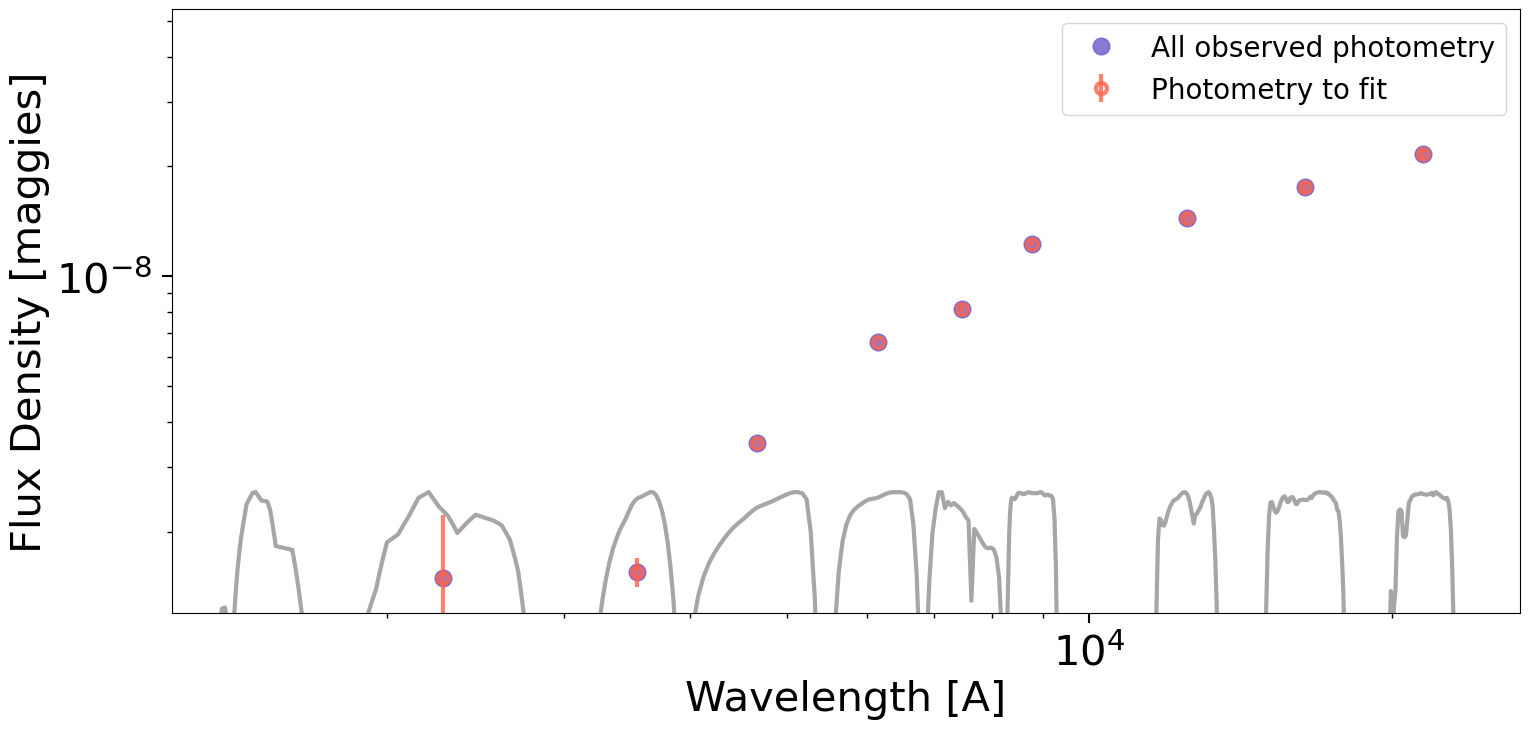

In [20]:
# Build the obs dictionary using the meta-parameters
obs = build_obs(attrs, spectr,**run_params)

# Look at the contents of the obs dictionary
print("Obs Dictionary Keys:\n\n{}\n".format(obs.keys()))
print("--------\nFilter objects:\n")
print(obs["filters"])

# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"][1:].min()*0.8, obs["maggies"][1:].max()/0.4
figure(figsize=(16,8))

# plot all the data
plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# overplot only the data we intend to fit
mask = obs["phot_mask"]
errorbar(wphot[mask], obs['maggies'][mask], 
         yerr=obs['maggies_unc'][mask], 
         label='Photometry to fit',
         marker='o', markersize=8, alpha=0.8, ls='', lw=3,
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
xscale("log")
yscale("log")
legend(loc='best', fontsize=20)
tight_layout()

## The model object: `build_model()`

Now we need a set of model parameters, which will **define** the model we are tying to fit to the data.  The model object stores the parameters that are used by the SPS object to build a spectrum, as well as infomation about which parameters are to be varied during fitting, and priors on those parameters.  It efficiently converts between a vector of parameter values (the `theta` attribute) used by the MCMC samplers or optimizers and the dictionary of parameter names and values (the `params` attribute) that can be passed to the sps objects' `get_spectrum()` method.

To create the model object we need a list or dictionary of model parameters and some infomation about them.  Each parameter must a have a `name`, a length `N` (vector parameters are possible), an initial value `ini`, and must be specified as either a free parameter or a fixed parameter via an `isfree` key.  If it is a free parameter it *must* have a prior specified as well, which we will get from the `priors` module.  Please see the documentation for that module for detaiuls on the available priors.

Let's start by creating a dictionary that describes a single parameter controlling the stellar mass.

In [21]:
from prospect.models import priors
mass_param = {"name": "mass",
              # The mass parameter here is a scalar, so it has N=1
              "N": 1,
              # We will be fitting for the mass, so it is a free parameter
              "isfree": True,
              # This is the initial value. For fixed parameters this is the
              # value that will always be used. 
              "init": 1e8,
              # This sets the prior probability for the parameter
              "prior": priors.LogUniform(mini=1e6, maxi=1e12),
              # this sets the initial dispersion to use when generating 
              # clouds of emcee "walkers".  It is not required, but can be very helpful.
              "init_disp": 1e6, 
              # this sets the minimum dispersion to use when generating 
              #clouds of emcee "walkers".  It is not required, but can be useful if 
              # burn-in rounds leave the walker distribution too narrow for some reason.
              "disp_floor": 1e6, 
              # This is not required, but can be helpful
              "units": "solar masses formed",
              }

Ok, that's the description for one parameter.  Let's **build up the rest of our model** as a dictionary of these parameter descriptions, keyed by parameter name.  The type of model you build will depend on your data, the type of object you are looking at,  and your scientific question. For this data, at a minimum we will need some sort of distance or redshift information (which in this example is a fixed parameter), and something descibing the SFH.  We could also add parameters controlling metallicity, dust attenuation and emission, nebular emission, even the IMF. Note that any parameter whose value is not explicitly specified via a model parameter dictionary will be given the default value from python-FSPS.

While we could keep adding parameters by hand, the easiest way to build up this model is to start with some predefined parameter sets from the `prospect.models.templates` module, and then modify them to suit our needs. First, lets look at what pre-packaged parameter sets are available.

In [22]:
from prospect.models.templates import TemplateLibrary

# Look at all the prepackaged parameter sets
TemplateLibrary.show_contents()

'type_defaults':
  Explicitly sets dust amd IMF types.
'ssp':
  Basic set of (free) parameters for a delta function SFH
'parametric_sfh':
  Basic set of (free) parameters for a delay-tau SFH.
'dust_emission':
  The set of (fixed) dust emission parameters.
'nebular':
  The set of nebular emission parameters, with gas_logz tied to stellar logzsol.
'nebular_marginalization':
  Marginalize over emission amplitudes line contained inthe observed spectrum
'fit_eline_redshift':
  Fit for the redshift of the emission lines separatelyfrom the stellar redshift
'agn_eline':
  Add AGN emission lines
'outlier_model':
  The set of outlier (mixture) models for spectroscopy and photometry
'agn':
  The set of (fixed) AGN dusty torus emission parameters.
'igm':
  The set of (fixed) IGM absorption parameters.
'spectral_smoothing':
  Set of parameters for spectal smoothing.
'optimize_speccal':
  Set of parameters (most of which are fixed) for optimizing a polynomial calibration vector.
'fit_speccal':
  Set

It looks like the `"parametric_sfh"` parameter set will do most of what we want.  Let's look at it in more detail.

In [23]:
TemplateLibrary.describe("parametric_sfh")

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: 0.1 
  sfh: 4 
  imf_type: 2 
  dust_type: 0 


That looks pretty good, this model has 5 free parameters:
- stellar mass *formed* $M_\star$,
- metallicity $\log Z/Z_\odot$, 
- age $t$ of the galaxy 
- star formation timescale $\tau$ for an exponentially declining star formation history (SFH), and
- dust attenuation optical depth for a foreground screen, $A_V$.

Everything else here is fixed explicitly (e.g. Chabrier IMF via `imf_type:2`).  There are many other `sps` parameters that are set implicitly in the FSPS defaults.  See the python-FSPS documentation for a complete list and details on the default values.

Note that by default the stellar mass here refers to the stellar mass *formed* by the given age, which will always be slightly higher than the *surviving* stellar mass, due to mass loss during stellar evolution (winds, SNe, etc.)

To tailor this model to our data we'll want to just adjust a couple of the initial values and priors, and add a parameter that will set the distance even though the redshift of theses objects is zero (remember we used absolute magnitudes - these particular very nearby objects are decoupled from the Hubble flow and have very small redshifts, or even blueshifts).

However, as for the ``obs`` dictionary we will do all this model building inside a method called ``build_model``.
This is useful because then we can control (at run-time) how the model is built via more meta-parameters.  For example the redshift of the model can be specified, or we can decide to change a prior depending on which object the model is fitting. Let's do an example where we change whether the metallicity is a free parameter of the fit or fixed to a particular value, optionally turn on dust emission in the model, and where we can set the redshift by hand as well.

In [24]:
def build_model(object_redshift=None, ldist=10.0, fixed_metallicity=None, add_duste=False, 
                **extras):
    """Build a prospect.models.SedModel object
    
    :param object_redshift: (optional, default: None)
        If given, produce spectra and observed frame photometry appropriate 
        for this redshift. Otherwise, the redshift will be zero.
        
    :param ldist: (optional, default: 10)
        The luminosity distance (in Mpc) for the model.  Spectra and observed 
        frame (apparent) photometry will be appropriate for this luminosity distance.
        
    :param fixed_metallicity: (optional, default: None)
        If given, fix the model metallicity (:math:`log(Z/Z_sun)`) to the given value.
        
    :param add_duste: (optional, default: False)
        If `True`, add dust emission and associated (fixed) parameters to the model.
        
    :returns model:
        An instance of prospect.models.SedModel
    """
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors

    # Get (a copy of) one of the prepackaged model set dictionaries.
    # This is, somewhat confusingly, a dictionary of dictionaries, keyed by parameter name
    model_params = TemplateLibrary["parametric_sfh"]
    
   # Now add the lumdist parameter by hand as another entry in the dictionary.
   # This will control the distance since we are setting the redshift to zero.  
   # In `build_obs` above we used a distance of 10Mpc to convert from absolute to apparent magnitudes, 
   # so we use that here too, since the `maggies` are appropriate for that distance.
    model_params["lumdist"] = {"N": 1, "isfree": False, "init": ldist, "units":"Mpc"}
    
    # Let's make some changes to initial values appropriate for our objects and data
    model_params["zred"]["init"] = 0.0
    model_params["dust2"]["init"] = 0.05
    model_params["logzsol"]["init"] = -0.5
    model_params["tage"]["init"] = 13.
    model_params["mass"]["init"] = 1e8
    
    # These are dwarf galaxies, so lets also adjust the metallicity prior,
    # the tau parameter upward, and the mass prior downward
    model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=2.0)
    model_params["tau"]["prior"] = priors.LogUniform(mini=1e-1, maxi=1e2)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e6, maxi=1e10)

    # If we are going to be using emcee, it is useful to provide a 
    # minimum scale for the cloud of walkers (the default is 0.1)
    model_params["mass"]["disp_floor"] = 1e6
    model_params["tau"]["disp_floor"] = 1.0
    model_params["tage"]["disp_floor"] = 1.0
    
    # Change the model parameter specifications based on some keyword arguments
    if fixed_metallicity is not None:
        # make it a fixed parameter
        model_params["logzsol"]["isfree"] = False
        #And use value supplied by fixed_metallicity keyword
        model_params["logzsol"]['init'] = fixed_metallicity 

    if object_redshift is not None:
        # make sure zred is fixed
        model_params["zred"]['isfree'] = False
        # And set the value to the object_redshift keyword
        model_params["zred"]['init'] = object_redshift

    if add_duste:
        # Add dust emission (with fixed dust SED parameters)
        # Since `model_params` is a dictionary of parameter specifications, 
        # and `TemplateLibrary` returns dictionaries of parameter specifications, 
        # we can just update `model_params` with the parameters described in the 
        # pre-packaged `dust_emission` parameter set.
        model_params.update(TemplateLibrary["dust_emission"])
        
    # Now instantiate the model object using this dictionary of parameter specifications
    model = SedModel(model_params)

    return model


run_params["object_redshift"] = object_redshift
run_params["fixed_metallicity"] = None
run_params["add_duste"] = True

Now let's build the model using this function and take a look at it:

In [25]:
model = build_model(**run_params)
print(model)
print("\nInitial free parameter vector theta:\n  {}\n".format(model.theta))
print("Initial parameter dictionary:\n{}".format(model.params))

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=1000000.0,maxi=10000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=100.0)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.29266] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  lumdist: [10.] 
  add_dust_emission: [ True] 
  duste_umin: [1.] 
  duste_qpah: [4.] 
  duste_gamma: [0.001] 

Initial free parameter vector theta:
  [ 1.0e+08 -5.0e-01  5.0e-02  1.3e+01  1.0e+00]

Initial parameter dictionary:
{'zred': array([0.29266]), 'mass': array([1.e+08]), 'logzsol': array([-0.5]), 'dust2': array([0.05]), 'sfh': array([4]), 'tage': array([13.]), 'imf_type': array([2]), 'dust_type':

## The source object: `build_sps()`

We are almost there, but we need an object that will build SEDs for a given set of parameters.  In *prospector* we call these *sps* objects.  Given a dictionary of parameters (provided by the model object), they must be able to return a spectrum and photometry -- corresponding to the data in the `obs` dictionary -- and maybe some ancillary information.  The generation of spectra and photometry is often done using large spectral libraries and, for galaxies, isochrone information.  Typically in *prospector* we use `fsps.StellarPopulation` objects, under thin wrappers that add a little functionality and change the API a bit. The different wrappers correspond to different SFH parameterizations. Here we use `CSPSpecBasis` which works with (linear combinations of) composite stellar populations,  as described in the FSPS manual with `sfh_type` of 1, 4, or 5.  Other `sps` objects can be used for non-parameteric SFH, notably `prospect.sources.FastStepBasis`.

Again, it can be helpful to encapsulate the loading of the sps object in a `load_sps` method, with meta-parameters controlling the how the object is instantiated

In [26]:
def build_sps(zcontinuous=1, **extras):
    """
    :param zcontinuous: 
        A vlue of 1 insures that we use interpolation between SSPs to 
        have a continuous metallicity parameter (`logzsol`)
        See python-FSPS documentation for details
    """
    from prospect.sources import CSPSpecBasis
    sps = CSPSpecBasis(zcontinuous=zcontinuous)
    return sps

run_params["zcontinuous"] = 1

This object often has a large memory footprint, since it contains all the spectral libraries and isochrones.
It has one very important method, `get_spectrum()`.  Indeed, the only definition of an `sps` object (for example if you want to make your own) is that it have this method.  In typical use, any FSPS parameter can be passed to this method as an extra keyword argument and the model will be built using that parameter.  Several additional parameters controlling, e.g., spectral smoothing or the wavelength calibration can also be passed to the default objects.

In [27]:
sps = build_sps(**run_params)
help(sps.get_spectrum)

Help on method get_spectrum in module prospect.sources.ssp_basis:

get_spectrum(outwave=None, filters=None, peraa=False, **params) method of prospect.sources.galaxy_basis.CSPSpecBasis instance
    Get a spectrum and SED for the given params.
    
    :param outwave: (default: None)
        Desired *vacuum* wavelengths.  Defaults to the values in
        ``sps.wavelength``.
    
    :param peraa: (default: False)
        If `True`, return the spectrum in erg/s/cm^2/AA instead of AB
        maggies.
    
    :param filters: (default: None)
        A list of filter objects for which you'd like photometry to be calculated.
    
    :param params:
        Optional keywords giving parameter values that will be used to
        generate the predicted spectrum.
    
    :returns spec:
        Observed frame spectrum in AB maggies, unless ``peraa=True`` in which
        case the units are erg/s/cm^2/AA.
    
    :returns phot:
        Observed frame photometry in AB maggies.
    
    :returns ma

## View the model
Now that we have the `sps` object we can also generate a prediction for the data from any set of model parameters.  To see how this works, lets make an SED and plot it!  This will use the initial parameter values for the model we built before.

Note that creating a new model with FSPS is somewhat time-intensive (of order seconds), but once the relevant SSPs have been built they are subsequently stored in cache so similar models can be generated much more quickly (of order milliseconds, unless you are changing parameters that affect the SSPs, like the IMF)

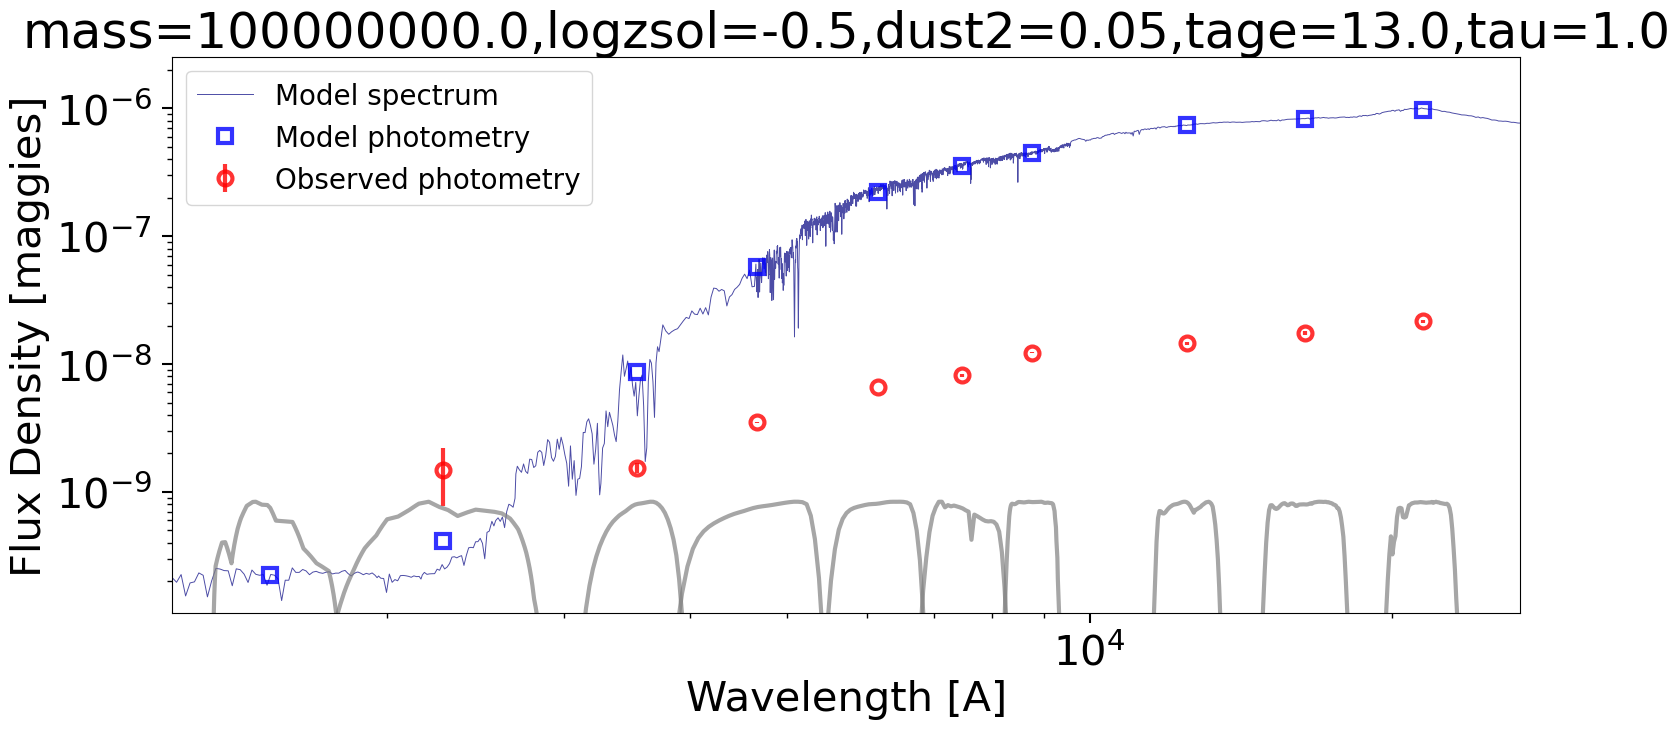

In [28]:
# Generate the model SED at the initial value of theta
theta = model.theta.copy()
initial_spec, initial_phot, initial_mfrac = model.sed(theta, obs=obs, sps=sps)
title_text = ','.join(["{}={:.3g}".format(p, model.params[p][0]) 
                       for p in model.free_params])

a = 1.0 + model.params.get('zred', 0.0) # cosmological redshifting
# photometric effective wavelengths
wphot = obs["phot_wave"]
# spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, initial_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4
figure(figsize=(16,8))

# plot model + data
loglog(wspec, initial_spec, label='Model spectrum', 
       lw=0.7, color='navy', alpha=0.7)
errorbar(wphot, initial_phot, label='Model photometry', 
         marker='s',markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry',
         marker='o', markersize=10, alpha=0.8, ls='', lw=3,
         ecolor='red', markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)
title(title_text)

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()


## Likelihood function
Now all we are missing is a likelihood function.  In most cases, this will simply be a function of the **spectral likelihood** and a **photometric likelihood** such that

$$
\mathcal{L} = f(\mathcal{L}_{\textrm{spec}}, \mathcal{L}_{\textrm{phot}}) \quad .
$$

Assuming our errors are Normal (i.e. Gaussian), the log-likelihoods for each component are extremely straightforward to define and can be imported directly from *prospector*.  How we choose to combine these likelihoods might vary depending on the particulars of our data. For the demo, our likelihood function for our model parameters $\boldsymbol{\theta}$ is just

$$
\ln\mathcal{L}(\boldsymbol{\theta}) = \ln\mathcal{L}_{\textrm{spec}}(\boldsymbol{\theta}) + \ln\mathcal{L}_{\textrm{phot}}(\boldsymbol{\theta}) \quad .
$$

Below is a simple version of the likelihood function used in *prospector*.  Note that more complicated likelihoods including covariant noise and fitted noise parameters are possible, using special NoiseModel classes within *prospector*.

For nested sampling `lnprobfn(theta, nested=True)` will return the likelihood (since the prior probability is accounted for by drawing proposals from the priors), while for other types of MCMC sampling `lnprobfn(theta, nested=False)` returns the posterior probability.

In [29]:
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

verbose = False
def lnprobfn(theta, model=None, obs=None, sps=None, 
             nested=False, verbose=verbose):
    """
    Given a parameter vector, a model, a dictionary of observational 
    data, and an sps object, return the ln of the posterior. 
    """

    # Calculate prior probability and exit if not within prior
    # Also if doing nested sampling, do not include the basic priors, 
    # since the drawing method includes the prior probability
    lnp_prior = model.prior_product(theta, nested=nested)
    if not np.isfinite(lnp_prior):
        return -np.infty
        
    # Generate "mean" model
    spec, phot, mfrac = model.mean_model(theta, obs, sps=sps)
 
    # Calculate likelihoods
    lnp_spec = lnlike_spec(spec, obs=obs)
    lnp_phot = lnlike_phot(phot, obs=obs)

    return lnp_prior + lnp_phot + lnp_spec

run_params["verbose"] = verbose

It can also be useful for some optimization methods (i.e. Levenberg-Marquardt) to define a function that returns the vector of chi-square residuals.  Let's do that.

In [30]:
from prospect.likelihood import chi_spec, chi_phot
def chivecfn(theta):
    """A version of lnprobfn that returns the simple uncertainty 
    normalized residual instead of the log-posterior, for use with 
    least-squares optimization methods like Levenburg-Marquardt.
    
    It's important to note that the returned chi vector does not 
    include the prior probability.
    """
    lnp_prior = model.prior_product(theta)
    if not np.isfinite(lnp_prior):
        return np.zeros(model.ndim) - np.infty

    # Generate mean model
    try:
        spec, phot, x = model.mean_model(theta, obs, sps=sps)
    except(ValueError):
        return np.zeros(model.ndim) - np.infty

    chispec = chi_spec(spec, obs)
    chiphot = chi_phot(phot, obs)
    return np.concatenate([chispec, chiphot])

However, *prospector* comes with a pre-built `lnprobfn` that can incorporate more complex noise models, and can be either return ln-probability or chi-square or a vector of residuals depending on the algorithm being used.  So let's use that:

In [31]:
from prospect.fitting import lnprobfn
help(lnprobfn)

Help on function lnprobfn in module prospect.fitting.fitting:

lnprobfn(theta, model=None, obs=None, sps=None, noise=(None, None), residuals=False, nested=False, negative=False, verbose=False)
    Given a parameter vector and optionally a dictionary of observational
    ata and a model object, return the matural log of the posterior. This
    requires that an sps object (and if using spectra and gaussian processes, a
    NoiseModel) be instantiated.
    
    :param theta:
        Input parameter vector, ndarray of shape (ndim,)
    
    :param model:
        SedModel model object, with attributes including ``params``, a
        dictionary of model parameter state.  It must also have
        :py:func:`prior_product`, and :py:func:`predict` methods
        defined.
    
    :param obs:
        A dictionary of observational data.  The keys should be
    
        + ``"wavelength"``  (angstroms)
        + ``"spectrum"``    (maggies)
        + ``"unc"``         (maggies)
        + ``"maggies

# Running Prospector
Now that we have defined the model and set up the data that we want to fit, we are ready to run *prospector*.  We will do this in a few steps.  First we will run all the convenience functions we made earlier to get the fitting ingredients and set up the output.  Then we will fit the model using 1) $\chi^2$ minimization; 2) ensemble MCMC sampler around the best location from the minimization 3) dynamic nested sampling with `dynesty`

In [32]:
# Here we will run all our building functions
obs = build_obs(attrs, spectr,**run_params)
sps = build_sps(**run_params)
model = build_model(**run_params)

# For fsps based sources it is useful to 
# know which stellar isochrone and spectral library
# we are using
print(sps.ssp.libraries)

(b'mist', b'miles', b'DL07  ')


We will use, appropriately enough, the `fit_model` method (with different options) for each of the three different ways of fitting the model described above.  Let's take a look at this method. 

In [33]:
from prospect.fitting import fit_model
help(fit_model)

Help on function fit_model in module prospect.fitting.fitting:

fit_model(obs, model, sps, noise=(None, None), lnprobfn=<function lnprobfn at 0x7fcc0862ef70>, optimize=False, emcee=False, dynesty=True, **kwargs)
    Fit a model to observations using a number of different methods
    
    :param obs:
        The ``obs`` dictionary containing the data to fit to, which will be
        passed to ``lnprobfn``.
    
    :param model:
        An instance of the :py:class:`prospect.models.SedModel` class
        containing the model parameterization and parameter state.  It will be
        passed to ``lnprobfn``.
    
    :param sps:
        An instance of a :py:class:`prospect.sources.SSPBasis` (sub-)class.
        Alternatively, anything with a compatible :py:func:`get_spectrum` can
        be used here. It will be passed to ``lnprobfn``
    
    :param noise: (optional, default: (None, None))
        A tuple of NoiseModel objects for the spectroscopy and photometry
        respectively.  Ca

Note in particular that the output is a dictionary with *both* optimization and sampling entries.  This is because one can do both within a single call to `fit_model`, and for ensemble sampling in particular it can be useful to do optimization first to get close to the data before beginnning the sampling.

## Minimization
We can attempt to initialize our model reasonably close to the data by using some numerical minimization routines.
Here we will use Levenberg-Marquardt. Keywords that control the optimization algorithm will again be stored in the `run_params` dictionary. Levenberg-Marquardt requires a likelihood function that returns a vector of chi values, not an actual likelihood, but the `lnprobfn` we imported supports that.

In [34]:
# --- start minimization ----
run_params["dynesty"] = False
run_params["emcee"] = False
run_params["optimize"] = True
run_params["min_method"] = 'lm'
# We'll start minimization from "nmin" separate places, 
# the first based on the current values of each parameter and the 
# rest drawn from the prior.  Starting from these extra draws 
# can guard against local minima, or problems caused by 
# starting at the edge of a prior (e.g. dust2=0.0)
run_params["nmin"] = 2

output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)

print("Done optmization in {}s".format(output["optimization"][1]))

/Users/dagoret/opt/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/models/priors.py:120: RuntimeWarning: divide by zero encountered in log
  lnp = np.log(p)


Done optmization in 114.64125275611877s


### View model after minimization
Now let's see how our model looks in the data space after minimization. The model should already be set to the result of the best optimization, but we can also find the best run and set the model parameters to that result by hand.

[ 9.36012794e+07 -3.93583098e-01  1.10644546e-01  1.37999999e+01
  7.14818693e-01]
0
[ 9.36012794e+07 -3.93583098e-01  1.10644546e-01  1.37999999e+01
  7.14818693e-01]


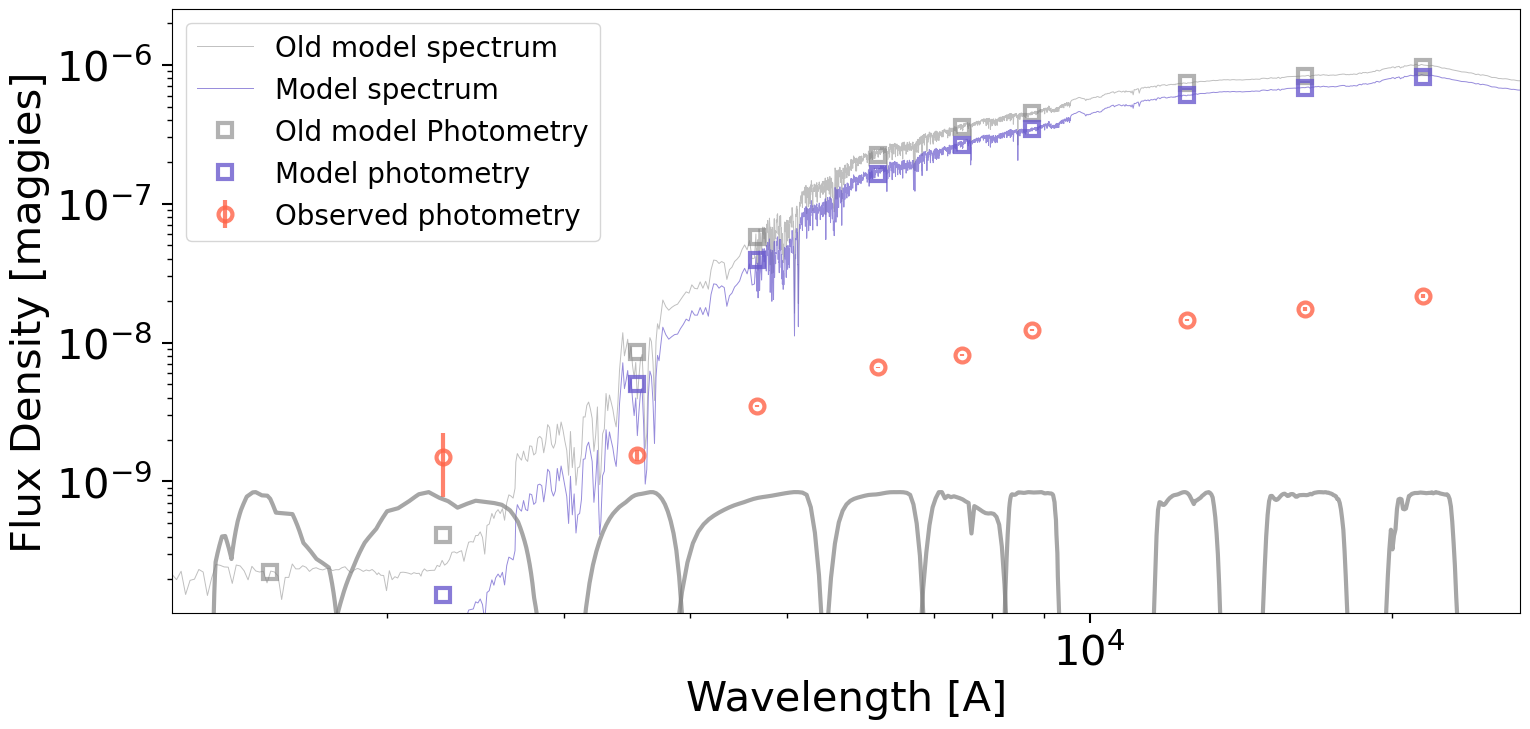

In [35]:
print(model.theta)
(results, topt) = output["optimization"]
# Find which of the minimizations gave the best result, 
# and use the parameter vector for that minimization
ind_best = np.argmin([r.cost for r in results])
print(ind_best)
theta_best = results[ind_best].x.copy()
print(theta_best)

# generate model
prediction = model.mean_model(theta_best, obs=obs, sps=sps)
pspec, pphot, pfrac = prediction

figure(figsize=(16,8))

# plot Data, best fit model, and old models
loglog(wspec, initial_spec, label='Old model spectrum',
       lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, initial_phot, label='Old model Photometry', 
         marker='s', markersize=10, alpha=0.6, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='gray', 
         markeredgewidth=3)
loglog(wspec, pspec, label='Model spectrum', 
       lw=0.7, color='slateblue', alpha=0.7)
errorbar(wphot, pphot, label='Model photometry', 
         marker='s', markersize=10, alpha=0.8, ls='', lw=3,
         markerfacecolor='none', markeredgecolor='slateblue', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'],
         label='Observed photometry', 
         marker='o', markersize=10, alpha=0.8, ls='', lw=3, 
         ecolor='tomato', markerfacecolor='none', markeredgecolor='tomato', 
         markeredgewidth=3)

# plot filter transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

# Prettify
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

That should look much better, except maybe for the filters that we have masked out.  You can also run the minimization cell multiple times to see if the fit gets better.

## Sampling the Posterior: Ensemble sampling
Now that we're somewhat burned in, we can begin sampling from the posterior using **Markov Chain Monte Carlo** (MCMC).  For this we will use the ensemble sampling agorithms in *emcee*

The algorithm used in *emcee* requires several options to be specified, related to the number of walkers, the number of iterations, and to rounds of burn-in.  For convenience we will store these in the `run_params` meta-parameter dictionary that we've been using. Sampling will begin with a cloud of walkers initialized around the current `model.theta` value, but optionally another round of optmization can be done before sampling begins.

In [36]:
# Set this to False if you don't want to do another optimization
# before emcee sampling (but note that the "optimization" entry 
# in the output dictionary will be (None, 0.) in this case)
# If set to true then another round of optmization will be performed 
# before sampling begins and the "optmization" entry of the output
# will be populated.
run_params["optimize"] = False
run_params["emcee"] = True
run_params["dynesty"] = False
# Number of emcee walkers
run_params["nwalkers"] = 128
# Number of iterations of the MCMC sampling
run_params["niter"] = 512
# Number of iterations in each round of burn-in
# After each round, the walkers are reinitialized based on the 
# locations of the highest probablity half of the walkers.
run_params["nburn"] = [16, 32, 64]

Let's go ahead and start sampling! (This should take of order 10 minutes)

In [37]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done emcee in {0}s'.format(output["sampling"][1]))

done emcee in 607.5484521389008s


### Write Output
Now that everything's all set, let's save our results to disk.  These will be written to an hdf5 file with the given name.

In [38]:
from prospect.io import write_results as writer
hfile = "demo_emcee_mcmc_" + output_tag + ".h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


/Users/dagoret/opt/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/Users/dagoret/opt/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize run_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/dagoret/opt/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/dagoret/opt/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


## Sampling the Posterior: Nested sampling
Instead of ensemble MCMC sampling we can sample using dynamic nested sampling via *dynesty*.  Dynamic nested sampling works by sampling from within successive iso-likelihood contours, transforming a distribution of live points from the prior to the posterior.  It does not benefit from burn-in via optimization.

There are a number of parameters that control the operation of *dynesty*.  A listing and brief description of each is given in the default *prospector* arguments (see below), here we will set just a few of the most important

In [39]:
run_params["dynesty"] = True
run_params["optmization"] = False
run_params["emcee"] = False
run_params["nested_method"] = "rwalk"
run_params["nlive_init"] = 400
run_params["nlive_batch"] = 200
run_params["nested_dlogz_init"] = 0.05
run_params["nested_posterior_thresh"] = 0.05
run_params["nested_maxcall"] = int(1e7)

In [40]:
output = fit_model(obs, model, sps, lnprobfn=lnprobfn, **run_params)
print('done dynesty in {0}s'.format(output["sampling"][1]))

iter: 14755 | batch: 20 | nc: 1 | ncall: 71725 | eff(%): 18.293 | loglstar: 100.244 < 109.294 < 108.260 | logz: 90.508 +/-  0.140 | stop:  1.028     

done dynesty in 630.6210329532623s


In [41]:
from prospect.io import write_results as writer
hfile = "demo_dynesty_mcmc_" +  output_tag+ ".h5"
writer.write_hdf5(hfile, run_params, model, obs,
                  output["sampling"][0], output["optimization"][0],
                  tsample=output["sampling"][1],
                  toptimize=output["optimization"][1])

print('Finished')

Finished


/Users/dagoret/opt/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/Users/dagoret/opt/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize run_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/dagoret/opt/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:290: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/dagoret/opt/anaconda3/envs/prospector/lib/python3.8/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


## Command-line operation

The preferred way to use prospector is through command line operation.  This is difficult to demonstrate in a notebook, but essentially one would place the `build_obs`, `build_model`, and `build_sps` methods in a single **parameter file**.  Then, in the `__main__` portion of the **parameter file** the entries of the `run_params` dictionary would be set via command-line arguments (via `argparse`), the `build_*` methods would be run, and `fit_model` would be called. For an example please see `demo_params.py` and `demo_mock_params.py` in the prospector demo directory.

A number of options used by the code are available in a prebuilt argument parser, which can be augmented with anything necessary for the `build_*` methods that you create.  Below is an example.

In [42]:
from prospect import prospect_args
# - Parser with default arguments -
parser = prospect_args.get_parser()
# - Add custom arguments -
parser.add_argument('--add_duste', action="store_true",
                    help="If set, add dust emission to the model.")
parser.add_argument('--ldist', type=float, default=10,
                    help=("Luminosity distance in Mpc. Defaults to 10"
                          "(for case of absolute mags)"))
args, _ = parser.parse_known_args()
cli_run_params = vars(args)
print(cli_run_params)

{'verbose': 1, 'debug': False, 'outfile': 'prospector_test_run', 'output_pickle': False, 'zcontinuous': 1, 'optimize': False, 'min_method': 'lm', 'min_opts': {}, 'nmin': 1, 'emcee': False, 'nwalkers': 64, 'niter': 512, 'nburn': [16, 32, 64], 'interval': 0.2, 'restart_from': '', 'initial_disp': 0.1, 'dynesty': False, 'nested_bound': 'multi', 'nested_sample': 'slice', 'nested_walks': 48, 'nested_nlive_init': 100, 'nested_nlive_batch': 100, 'nested_dlogz_init': 0.05, 'nested_maxcall': 50000000, 'nested_maxiter': 1000000, 'nested_maxbatch': 10, 'nested_bootstrap': 0, 'nested_target_n_effective': 10000, 'add_duste': False, 'ldist': 10}


# Visualizing the Results
There are a few basic plotting tools available to do a quick check on the results available in `prospect.io.read_results` and `prospect.utils.plotting`. But first we need to read the output files we made.

## Reading output files
Reading our results from our HDF5 file is straightforward using the `results_from` method.  This returns a "results" dictionary, the `obs` dictionary of data to which the model was fit, and in some situations the `SedModel` object that was used in the fitting.

In this example we will look at the *emcee* results file that we created, but you can do the same for the *dynesty* results file.  The main difference is that the chains for each fit type have a different dimensionality, and that the samples in the *dynesty* chains come with associated **weights**.  The weights and different shapes are handled automatically by the plotting functions included in *prospector*, but custom plotting code should take care of the difference.

In this notebook we have already defined the `model` (and `sps`) object, but in general one will want to recreate it.  *Prospector* allows you to do this by storing the `build_model` and `build_sps` code as text in the HDF5 file -- this is possible with the use of *parameter files* and command line operation.

In [43]:
import prospect.io.read_results as reader
results_type = "emcee" # | "dynesty"
# grab results (dictionary), the obs dictionary, and our corresponding models
# When using parameter files set `dangerous=True`
result, obs, _ = reader.results_from("demo_{}_mcmc_{}.h5".format(results_type,output_tag), dangerous=False)

#The following commented lines reconstruct the model and sps object, 
# if a parameter file continaing the `build_*` methods was saved along with the results
#model = reader.get_model(result)
#sps = reader.get_sps(result)

# let's look at what's stored in the `result` dictionary
print(result.keys())

dict_keys(['model_params', 'optimizer_duration', 'paramfile_text', 'prospector_version', 'run_params', 'acceptance', 'chain', 'initial_theta', 'lnprobability', 'sampling_initial_center', 'rstate', 'sampling_duration', 'theta_labels', 'bestfit', 'optimization', 'obs', 'model'])


## Plotting parameter traces
To see how our MCMC samples look, we can examine a few traces (that is, the evolution of the parameter value with iteration in the MCMC chain.)  You can use these plots (and the chains more generally) to assess whether the MCMC has converged, or if you need to sample for more iterations.

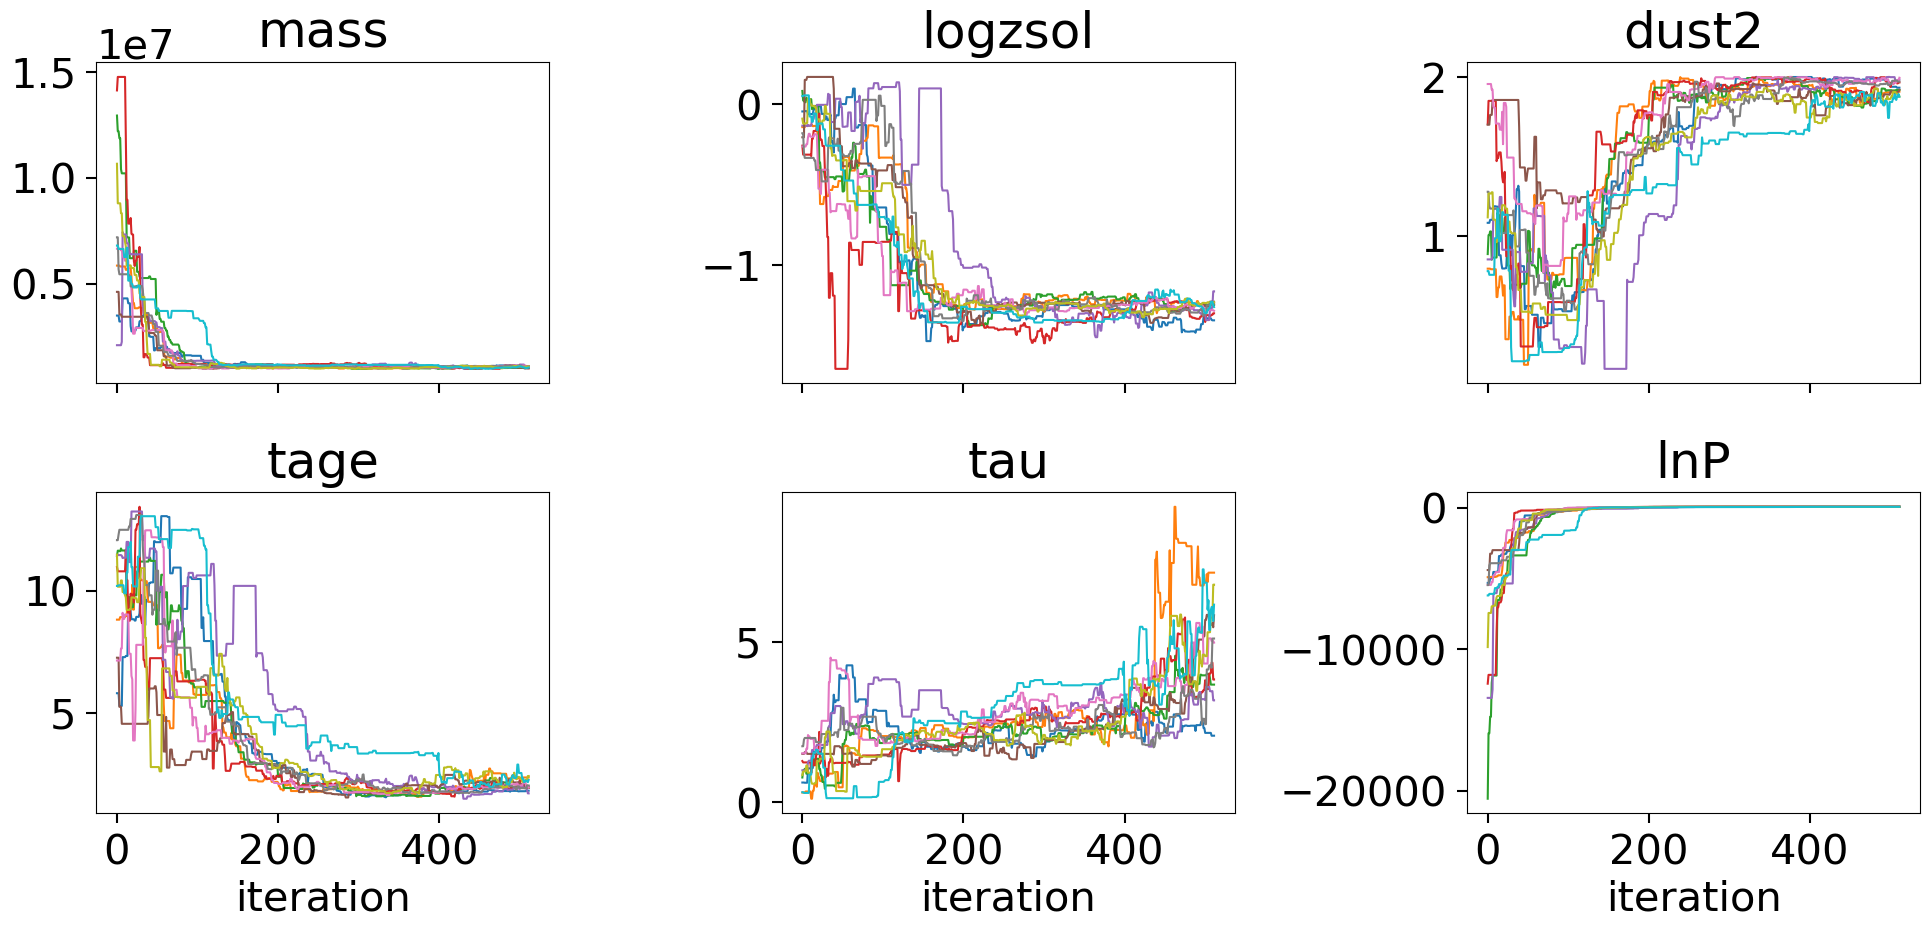

In [44]:
if results_type == "emcee":
    chosen = np.random.choice(result["run_params"]["nwalkers"], size=10, replace=False)
    tracefig = reader.traceplot(result, figsize=(20,10), chains=chosen)
else:
    tracefig = reader.traceplot(result, figsize=(20,10))


## Making a corner plot
Our samples more generally can be shown using a corner/triangle plot.  The `subtriangle()` method below is a very thin wrapper on Dan Foreman-Mackey's **corner.py** code.  We'll overplot the MAP value as blue lines.

Optimization value: [ 9.36012794e+07 -3.93583098e-01  1.10644546e-01  1.37999999e+01
  7.14818693e-01]
MAP value: [ 1.07961010e+06 -1.25455136e+00  1.99200343e+00  1.87732896e+00
  5.15312483e+00]


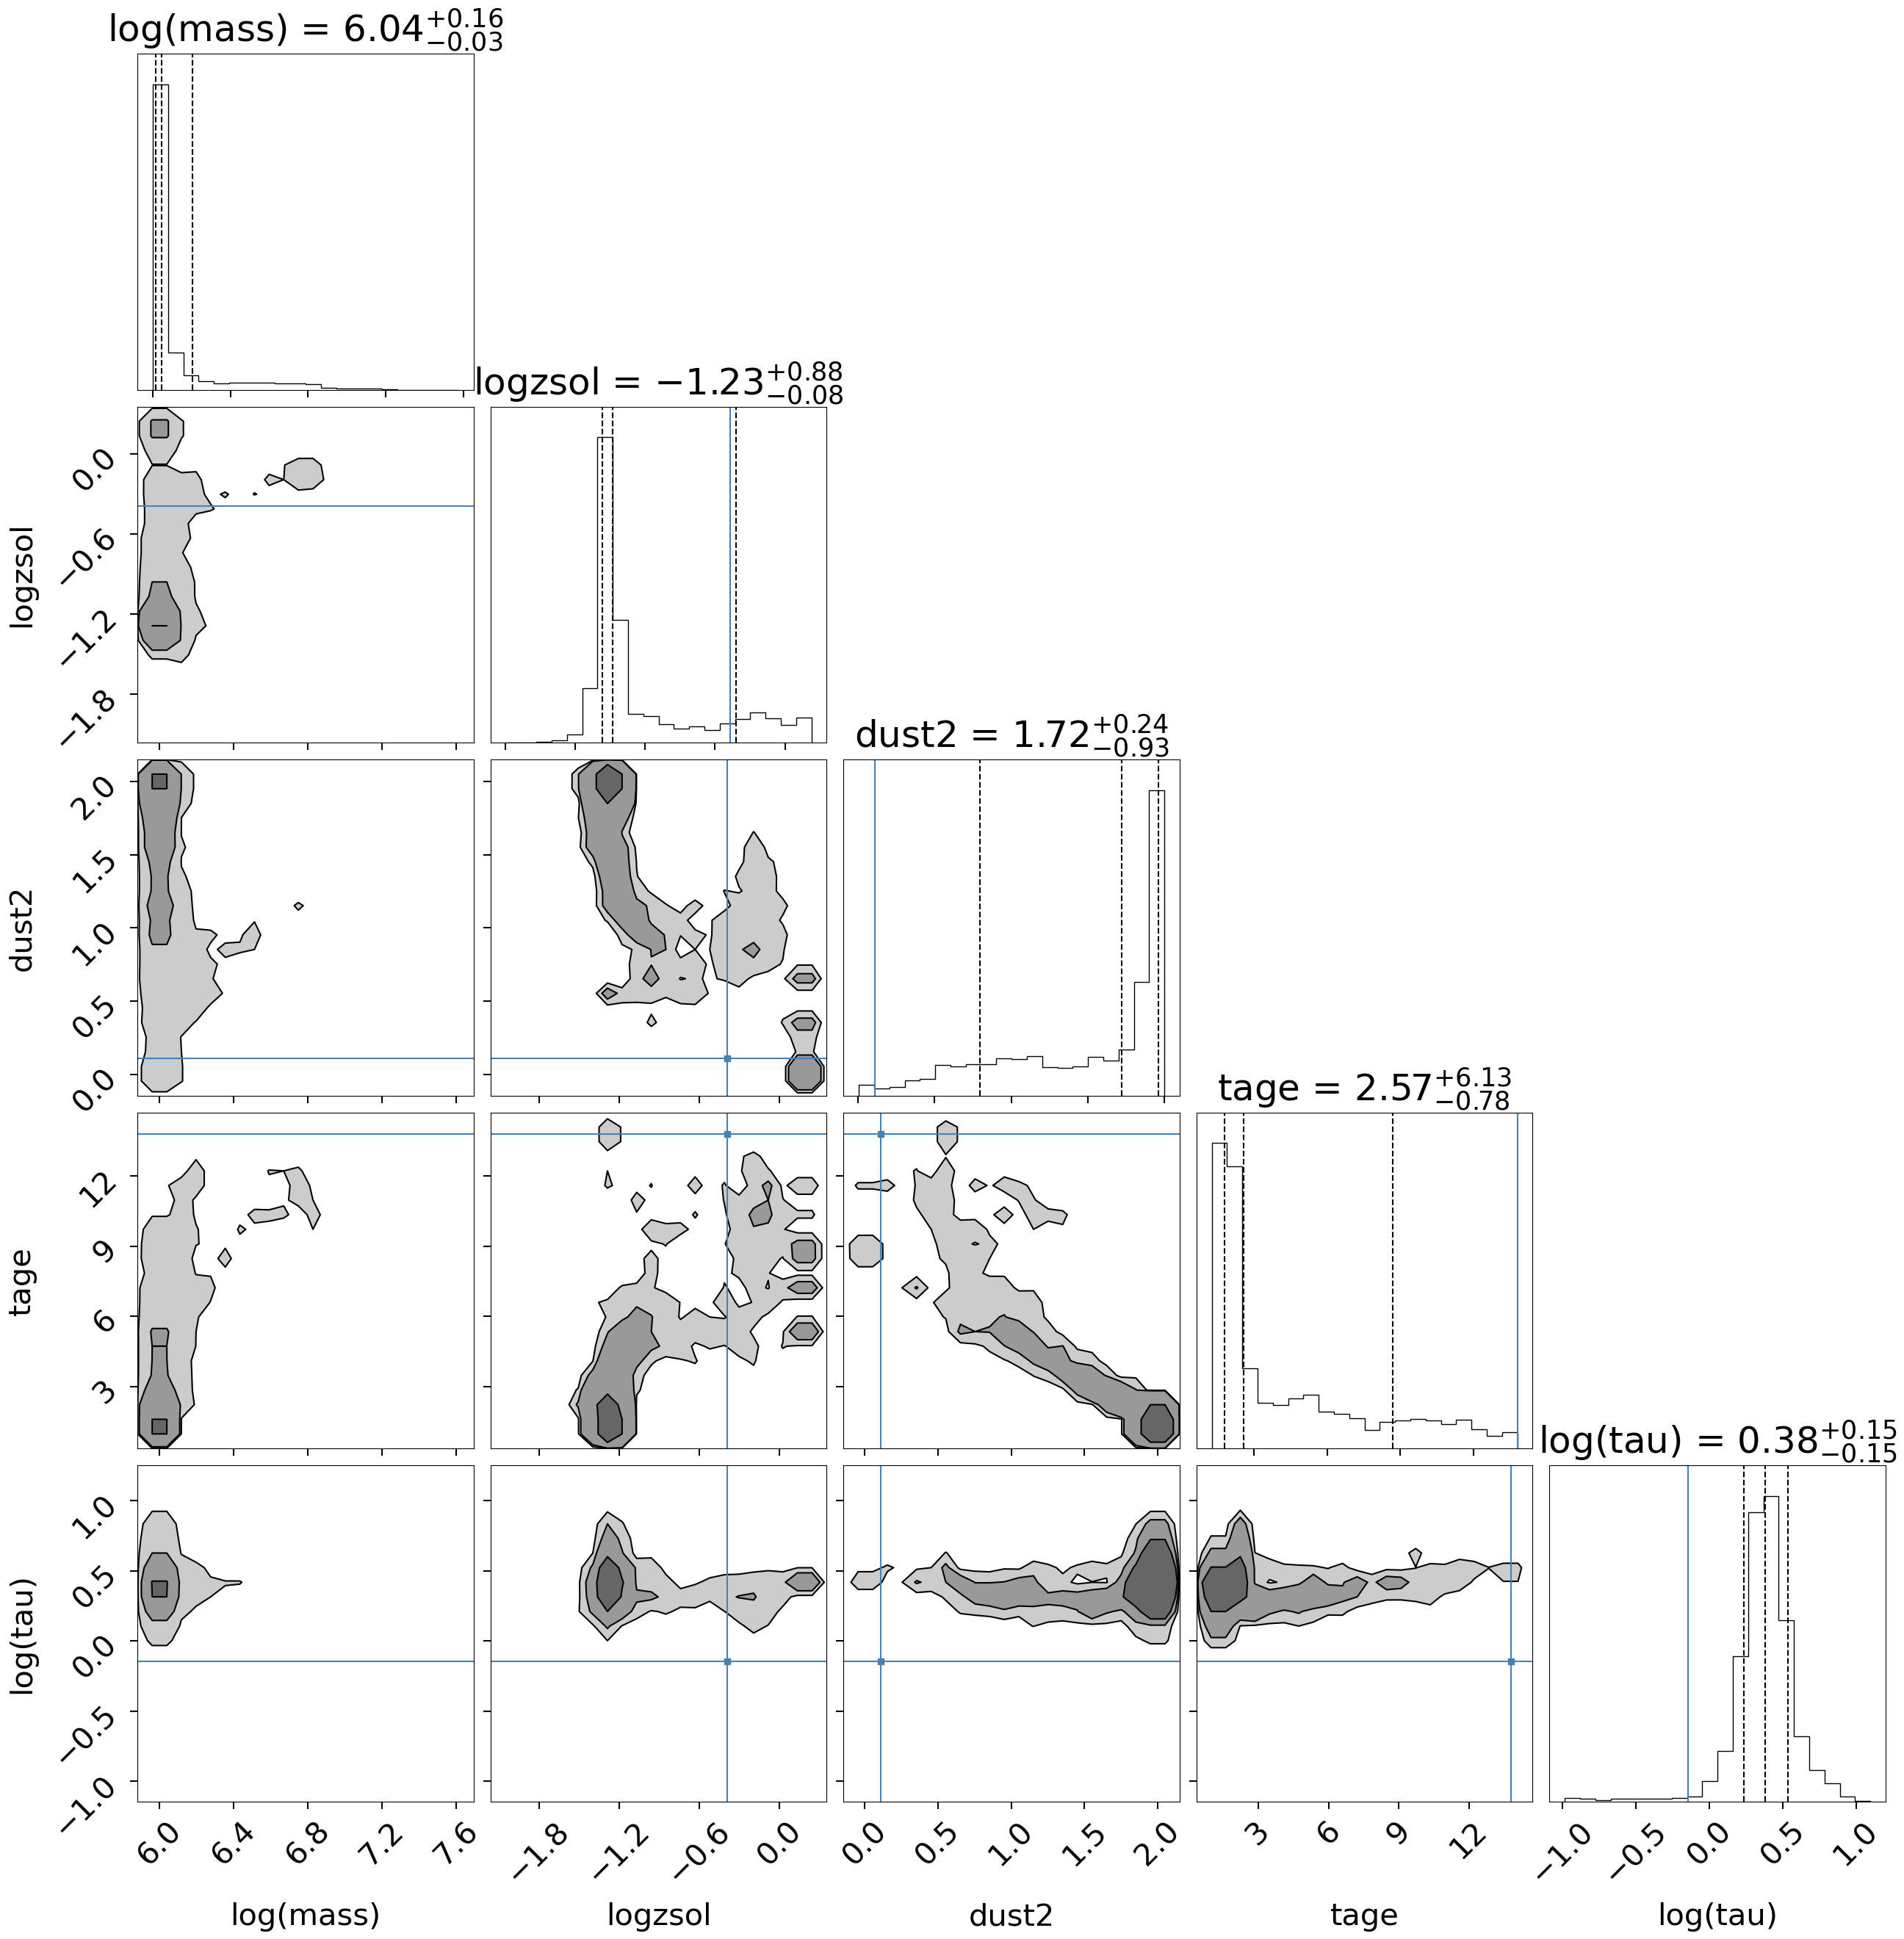

In [45]:
# maximum a posteriori (of the locations visited by the MCMC sampler)
imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_max = result["chain"][imax, :]
    thin = 1

print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_max))
cornerfig = reader.subcorner(result, start=0, thin=thin, truths=theta_best, 
                             fig=subplots(5,5,figsize=(27,27))[0])

## Look at SEDs and residuals
Finally, let's just take a look at a random model drawn from our chains, and at the highest posterior probability model in the chain.  In this notebook we already have the `sps` object instantiated, but in general we may have to regenerate it based on information stored in the output file using the `prospect.io.read_results.get_sps` method.

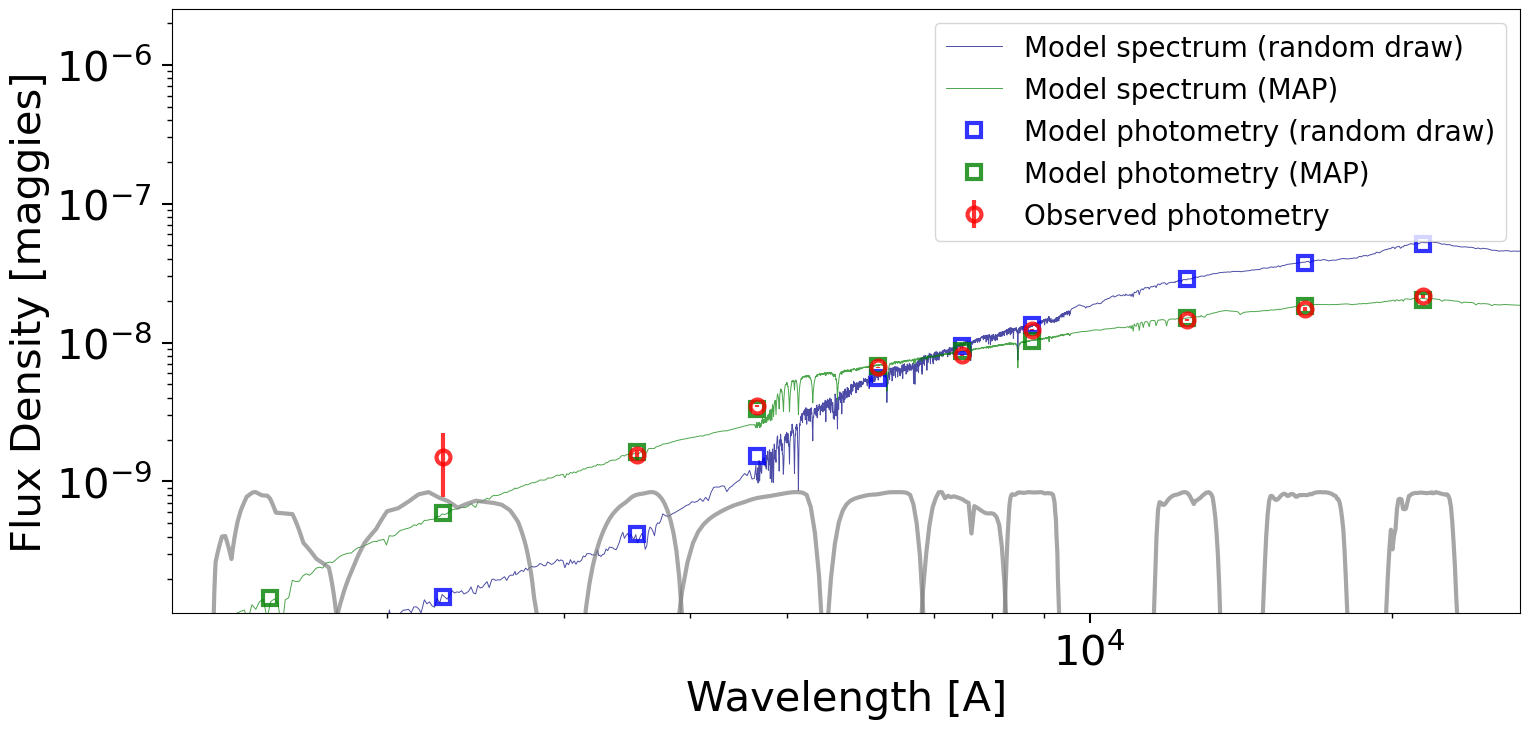

In [46]:
# randomly chosen parameters from chain
randint = np.random.randint
if results_type == "emcee":
    nwalkers, niter = run_params['nwalkers'], run_params['niter']
    theta = result['chain'][randint(nwalkers), randint(niter)]
else:
    theta = result["chain"][randint(len(result["chain"]))]

# generate models
# sps = reader.get_sps(result)  # this works if using parameter files
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps)
mspec_map, mphot_map, _ = model.mean_model(theta_max, obs, sps=sps)

# Make plot of data and model
figure(figsize=(16,8))

loglog(wspec, mspec, label='Model spectrum (random draw)',
       lw=0.7, color='navy', alpha=0.7)
loglog(wspec, mspec_map, label='Model spectrum (MAP)',
       lw=0.7, color='green', alpha=0.7)
errorbar(wphot, mphot, label='Model photometry (random draw)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='blue', 
         markeredgewidth=3)
errorbar(wphot, mphot_map, label='Model photometry (MAP)',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='green', 
         markeredgewidth=3)
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=3)

# plot transmission curves
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)

xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()